In [20]:
import pandas as pd
data = pd.read_csv(f'../data/total.csv')

    The following table is a view of the raw data from the scrape. I'll build the target by reducing the pay column to floating point values; this will require text cleaning which will also be conducted for the rest of the table. Location will be split into new columns for City and State while and because Indeed's search results show dates relative to the date the query was made I'll need to use PostDate and ExtractDate build a DatePosted column. It is important to note that JobUrl and date-related columns will not be converted into features for the logistic regression, instead they will be reattached to the data at the end in order to provide additional information and insights through the EC2 application. The only rows that'l  be using for modelling are JobTitle, Company, Summary, Requirements, and Description.

In [2]:
data.head()

,JobTitle,Company,Location,PostDate,ExtractDate,Summary,Pay,JobUrl,Requirements,Description
0,Analyst - Data Scientist,United Airlines Inc.,"Chicago, IL",Today,2021-06-18,Ready to learn and an interest in data science...,NaN,https://www.indeed.com/rc/clk?jk=a1d3fe07f5b59...,None,We have a wide variety of career opportunities...
1,Deep Learning Data Scientist,Intel,"Santa Clara, CA",Today,2021-06-18,"Bachelors in Computer science, Data science, C...",NaN,https://www.indeed.com/rc/clk?jk=d4acb9696d3f5...,None,Job DescriptionJoin Intel-and build a better t...
2,Data Scientist,Density Inc.,Remote,Today,2021-06-18,3+ years experience as a data scientist. Exten...,NaN,https://www.indeed.com/company/Density-Inc./jo...,None,"At Density, we build one of the most advanced ..."
3,Data Scientist Intermediate,Cone Health,"Greensboro, NC",Today,2021-06-18,The ability to design and apply multiple advan...,NaN,https://www.indeed.com/rc/clk?jk=fae261040a53b...,None,"LOCATION: Cone Health, SW-Enter Analytics - Co..."
4,DATA ANALYST,University of Washington,"Seattle, WA",Today,2021-06-18,Proven interest in health financing or malaria...,NaN,https://www.indeed.com/rc/clk?jk=58b049c2565c2...,None,"As a UW employee, you have a unique opportunit..."


In [3]:
null = sum(data.Pay.isnull())
nnull = sum(data.Pay.notnull())
print(data.isnull().sum())
print('')
print(f'The data contains {data.shape[0]} rows of individual job postings with values for {data.shape[1]} columns based on\n different sections of each post\'s web page.')
print('')
print(f'- Out of {len(data)} job postings {nnull} or {round(nnull/len(data)*100,2)}% include some sort of salary information,\n- The remaining {null} rowws, or {round(null/len(data)*100,2)}% are missing salary data.\n- Also, there are no null values in the rest of the table meaning we won\'t need\n  to lose any data by dropping rows. While the null values in the Pay column will\n  simply be dropped after we translate the not nulls into the target.')

JobTitle           0
Company            0
Location           0
PostDate           0
ExtractDate        0
Summary            0
Pay             5489
JobUrl             0
Requirements       0
Description        0
dtype: int64

The data contains 6105 rows of individual job postings with values for 10 columns based on
 different sections of each post's web page.

- Out of 6105 job postings 616 or 10.09% include some sort of salary information,
- The remaining 5489 rowws, or 89.91% are missing salary data.
- Also, there are no null values in the rest of the table meaning we won't need
  to lose any data by dropping rows. While the null values in the Pay column will
  simply be dropped after we translate the not nulls into the target.


In [4]:
print('Here we can observe the sort of values held in the Pay column. Aside from removing special characters and spaces I\'ll extract\n the remaing non-numeric chars into a new column that\'ll allow me to build the annual Salary column once the remaining\n numeric string are converted to floating point.')

samples = []
for i in np.unique(data[data['Pay'].notnull()].Pay):
    samples.append(i)
samples[:10]

Here we can observe the sort of values held in the Pay column. Aside from removing special characters and spaces I'll extract
 the remaing non-numeric chars into a new column that'll allow me to build the annual Salary column once the remaining
 numeric string are converted to floating point.


['$10 - $15 an hour',
 '$100 - $150 an hour',
 '$100,000 - $110,000 a year',
 '$100,000 - $120,000 a year',
 '$100,000 - $125,000 a year',
 '$100,000 - $128,000 a year',
 '$100,000 - $130,000 a year',
 '$100,000 - $135,000 a year',
 '$100,000 - $140,000 a year',
 '$100,000 - $145,000 a year']

In [21]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 17

import seaborn as sns
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)


def munge():
    """[Cleaning and Featuring Engineering]

    Args:
        position ([string]): [identifier for scraped dataset]

    Returns:
        [csv]: [data prepared for ML]
    """
    # Using the position variable to select/process scraped data based the on the query that
    # generated it.
    data = pd.read_csv(f'../data/total.csv', index_col=1)
    #TODO just name is salary in scrape.py

    

    def states_(i):
        """[Builds 'State' feature by splitting 'Location']

        Args:
            i ([row of data]): ['Location' value]

        Returns:
            [string]: [state name abbrieviation]
        """
        states = {"AL":"Alabama", "AK":"Alaska", "AS":"American Samoa", "AZ":"Arizona", "AR":"Arkansas",
        "CA":"California", "CO":"Colorado", "CT":"Connecticut", "DE":"Delaware", "DC":"District of Columbia",
        "FL":"Florida", "GA":"Georgia", "GU":"Guam", "HI":"Hawaii", "ID":"Idaho", "IL":"Illinois", "IN":"Indiana",
        "IA":"Iowa", "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "ME":"Maine", "MD":"Maryland", "MA":"Massachusetts",
        "MI":"Michigan", "MN":"Minnesota", "MS":"Mississippi", "MO":"Missouri", "MT":"Montana", "NE":"Nebraska",
        "NV":"Nevada", "NH":"New Hampshire", "NJ":"New Jersey", "NM":"New Mexico", "NY":"New York", "NC":"North Carolina",
        "ND":"North Dakota", "MP":"Northern Mariana Islands", "OH":"Ohio", "OK":"Oklahoma", "OR":"Oregon", "PA":"Pennsylvania",
        "PR":"Puerto Rico", "RI":"Rhode Island", "SC":"South Carolina", "SD":"South Dakota", "TN":"Tennessee",
        "TX":"Texas", "UT":"Utah", "UM":"U.S. Minor Outlying Islands", "VT":"Vermont", "VI":"Virgin Islands", "VA":"Virginia",
        "WA":"Washington", "WV":"West Virginia", "WI":"Wisconsin", "WY":"Wyoming"}
        extras = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut", "District ", "of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
        try:
            # These two values are sometimes present instead of a specific state
            if i == 'United States':
                return 'United States'
            elif i == 'Remote':
                return 'Remote'
            elif i == 'New York State':
                return 'NY'
            elif i == 'Washington State':
                return 'WA'
            
            #elif i in extras:
                #return i
            # if neither of the above are all we've been given, we can pull the
            # abbrieviation.
            else:
                for k,v in states.items():
                    if i[-2:] == k:
                        return k
                    elif i == v:
                        return k
        except:
            return i


    def cities_(i):
        """[Builds 'City' feature by splitting 'Location']

        Args:
            i ([row of data]): ['Location' value]

        Returns:
            [string]: [city name from 'Location']
        """
        states = {"AL":"Alabama", "AK":"Alaska", "AS":"American Samoa", "AZ":"Arizona", "AR":"Arkansas",
        "CA":"California", "CO":"Colorado", "CT":"Connecticut", "DE":"Delaware", "DC":"District of Columbia",
        "FL":"Florida", "GA":"Georgia", "GU":"Guam", "HI":"Hawaii", "ID":"Idaho", "IL":"Illinois", "IN":"Indiana",
        "IA":"Iowa", "KS":"Kansas", "KY":"Kentucky", "LA":"Louisiana", "ME":"Maine", "MD":"Maryland", "MA":"Massachusetts",
        "MI":"Michigan", "MN":"Minnesota", "MS":"Mississippi", "MO":"Missouri", "MT":"Montana", "NE":"Nebraska",
        "NV":"Nevada", "NH":"New Hampshire", "NJ":"New Jersey", "NM":"New Mexico", "NY":"New York", "NC":"North Carolina",
        "ND":"North Dakota", "MP":"Northern Mariana Islands", "OH":"Ohio", "OK":"Oklahoma", "OR":"Oregon", "PA":"Pennsylvania",
        "PR":"Puerto Rico", "RI":"Rhode Island", "SC":"South Carolina", "SD":"South Dakota", "TN":"Tennessee",
        "TX":"Texas", "UT":"Utah", "UM":"U.S. Minor Outlying Islands", "VT":"Vermont", "VI":"Virgin Islands", "VA":"Virginia",
        "WA":"Washington", "WV":"West Virginia", "WI":"Wisconsin", "WY":"Wyoming"}

        try:
            # Again, these are sometimes used instead of city, state.
            if i == 'United States':
                return ''
            elif i == 'Remote':
                return 'Remote'
            else:
                city = i[0:-2].strip().replace(',', '')
                return city
        except:
            'None'


    def count_dupes(data):
        """[Small helper for quick data integrity check]

        Args:
            data ([DataFrame]): [scrapped data]

        Returns:
            [tuple]: [number of duplicates (if any), number of unique values]
        """
        dupe = 0
        uniq = 0
        for i in data:
            if i == True:
                dupe += 1
            else:
                uniq +=1
        return dupe, uniq


    def deduper(data):
        """[Dropes duplicates]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now without dupes]
        """
        data = data.drop_duplicates()
        data = data.reset_index(drop=False, inplace=False)
        return data


    def sal_chars(data):
        """[Reduces Pay values to alphanumeric chars only]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now with no special chars]
        """
        data["Pay"] = data["Pay"].str.replace("\n", "")
        data["Pay"] = data["Pay"].str.replace(",", "")
        data["Pay"] = data["Pay"].str.replace("$", "", regex=False)
        return data


    def Pay_period(data):
        """[Builds a column for rate of Pay so a yearly salary can be computed]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now with Pay periods]
        """
        data['Schedule'] = np.nan
        data['Schedule'] = np.where(data['Pay'].str.contains("hour"),"hour",data['Schedule'])
        data['Schedule'] = np.where(data['Pay'].str.contains("week"),"week",data['Schedule'])
        data['Schedule'] = np.where(data['Pay'].str.contains("day"),"day",data['Schedule'])
        data['Schedule'] = np.where(data['Pay'].str.contains("year"),"year",data['Schedule'])
        data['Schedule'] = np.where(data['Pay'].str.contains("NaN"),np.nan,data['Schedule'])
        return data


    def sal_strings(data):
        """[Reduces Pay values to numeric chars only]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now with only numeric chars in Pay col]
        """
        data["Pay"] = data["Pay"].str.replace(" an hour", "")
        data["Pay"] = data["Pay"].str.replace(" a day", "")
        data["Pay"] = data["Pay"].str.replace(" a week", "")
        data["Pay"] = data["Pay"].str.replace(" a month", "")
        data["Pay"] = data["Pay"].str.replace(" a year", "")
        return data


    def split_sal(i):
        """[Converts salaries given as a range to the average of their min/max]

        Args:
            i ([row]): [applied to 'Pay' column]

        Returns:
            [float]: [If given a range, its mean]
        """
        try:
            lst = i.split(' - ',1)
            x = lst[0]
            y = lst[1]
            return (float(x)+float(y))//2
        except:
            return i

    def from_(i):
        #TODO I think this is too simple, find a way to include data that
        # may fall within a range.
        """[If salary is given with a base amount, returns that]

        Args:
            i ([row]): [applied to 'Pay' column]

        Returns:
            [string]: [Lower limit, if given]
        """
        try:
            lst = i.split('From ',1)
            y = lst[1]
            return (y)
        except:
            return i


    def up_to(i):
        # TODO combine this with the above
        """[If salary is given with a max amount, returns that]

        Args:
            i ([row]): [applied to 'Pay' column]

        Returns:
            [string]: [Upper limit, if given]
        """
        try:
            lst = i.split('Up to ',1)
            y = lst[1]
            return (y)
        except:
            return i



    def pDate(row):
        #TODO 64?
        """[Builds a column for date posted. since Indeed.com only gives values for
        postdate relative to day of query.]

        Args:
            i ([row]): [applied to 'PostDate' column]

        Returns:
            [date]: [The actual date the posting was created]
        """
        days_ago = row['PostDate']
        delta = timedelta(days_ago)
        try:
            return row['ExtractDate'] - delta
        except:
            return row


    def annual(data):
        """[Builds an annual salary feature with values for all data]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now with annual salary values]
        """
        data['Salary'] = np.nan
        data['Salary'] = np.where(data['Schedule'].str.contains("hour"), data['Pay']*365/7*40, data['Salary'])
        data['Salary'] = np.where(data['Schedule'].str.contains("day"), data['Pay']*365/7*5, data['Salary'])
        data['Salary'] = np.where(data['Schedule'].str.contains("week"), data['Pay']*365/7, data['Salary'])
        data['Salary'] = np.where(data['Schedule'].str.contains("month"), data['Pay']*365/12, data['Salary'])
        data['Salary'] = np.where(data['Schedule'].str.contains("year"), data['Pay'], data['Salary'])
        return data


    def acronyms(data):
        """[Spells out some commonly encountered acronyms. Supports accuracy of text analysis.]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now with fewer acronymns]
        """
        data["JobTitle"] = data["JobTitle"].str.replace("R&D", "research development")
        data["Summary"] = data["Summary"].str.replace("R&D", "research development")
        data["Description"] = data["Description"].str.replace("R&D", "research development")
        return data


    def chars(data):
        """[summary]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now without special chars]
        """
        cleaning_list = ["+", "$", "/", ",", "?", ".", ";", ":", "-", "@", "!", "&", "%", "^", "*", ")", "(", "\n"]
        for item in cleaning_list:
            data['PostDate'] = data['PostDate'].str.replace(item, " ", regex=False)
            data['Summary'] = data['Summary'].str.replace(item, " ",regex=False)
            data['Description'] = data['Description'].str.replace(item, " ",regex=False)
        return data


    def postD_int(data):
        """[Reduces or converts relative post dates to numeric chars]

        Args:
            data ([DataFrame]): [in munging]

        Returns:
            [DataFrame]: [Now with only numeric values for post date]
        """
        data["PostDate"] = data["PostDate"].str.replace("Active ", "")
        data["PostDate"] = data["PostDate"].str.replace(" day ago", "")
        data["PostDate"] = data["PostDate"].str.replace("%+ days ago", "")
        data["PostDate"] = data["PostDate"].str.replace("+", "")
        data["PostDate"] = data["PostDate"].str.replace(" days ago", "")
        data["PostDate"] = data["PostDate"].str.replace("Just posted", "0")
        data["PostDate"] = data["PostDate"].str.replace("Today", "0")
        data["PostDate"] = data["PostDate"].str.replace("today", "0")
        data['PostDate'] = data['PostDate'].astype('int')
        return data
    


    def roles(data):
        """[Supports web app display by providing website view table with information
        releavent to the job role.]

        Args:
            data ([DataFrame]): [munged]

        Returns:
            [DataFrame]: [Now with specific jobs and roles for each listing]
        """
        #Primary Role
        data['Role'] = ''
        analyst = ['anal']
        eng = ['big data', 'engin', 'data manag', 'data officer']
        ds = ['data scien', 'ml', 'deep', 'model', 'modeler','machine', 'deep', 'ai', 'scientist']


        data['Role'] = np.where(data['Role'].str.contains(''), 'Other', data['Role'])
        for _ in analyst:
            data['Role'] = np.where(data['JobTitle'].str.contains(_), 'data analyst', data['Role'])
        for _ in eng:
            data['Role'] = np.where(data['JobTitle'].str.contains(_), 'data engineer', data['Role'])
        for _ in ds:
            data['Role'] = np.where(data['JobTitle'].str.contains(_), 'data scientist', data['Role'])


        #Focus
        data['Focus'] = ''
        ml = ['ml', 'deep', 'model', 'modeler','machine', 'deep', 'ai']
        sr = ['sr.', 'lead', 'senior', 'manager']
        applied = ['applied']

        for _ in analyst:
            data['Focus'] = np.where(data['JobTitle'].str.contains(_), 'analysis', data['Focus'])
        for _ in ml:
            data['Focus'] = np.where(data['JobTitle'].str.contains(_), 'machine learning', data['Focus'])
        for _ in sr:
            data['Focus'] = np.where(data['JobTitle'].str.contains(_), 'senior', data['Focus'])
        return data

    # Apply the above functions to the selected DataFrame
    # These are in a neceassary order of operation as many functions require some cleaning or
    # featurization to have occured prior to their call/application.
    data["State"] = data["Location"].apply(states_)
    data["City"] = data["Location"].apply(cities_)
    data['ExtractDate']= pd.to_datetime(data['ExtractDate'])
    data = chars(data)
    data = postD_int(data)
    data['DatePosted'] = data.apply( lambda row : pDate(row), axis = 1)
    data = deduper(data)
    data = sal_chars(data)
    data = Pay_period(data)
    data = sal_strings(data)
    data["Pay"] = data["Pay"].apply(split_sal)
    data["Pay"] = data["Pay"].apply(from_)
    data["Pay"] = data["Pay"].apply(up_to)
    data['Pay'] = pd.to_numeric(data['Pay'])
    data = annual(data)
    data = acronyms(data)


    

    # Drop a few cols we no longer need
    data.drop(columns=['Pay','ExtractDate', 'PostDate'], inplace=True)

    for item in ['JobTitle', 'Company', 'Summary', 'Requirements','Description', 'City']:
        data[item] = data[item].str.lower()
    data = roles(data)
    data.to_csv(f'../data/munged_data.csv', index=False)
    return data




In [6]:
munged = munge()

In [7]:
null = len(munged[munged.Salary.isnull()])
nnull = len(munged[munged.Salary.notnull()])
print(f'Droping {len(data)-len(munged)} duplicates leaves {len(munged)} rows of data for the regressor to be trained and tested on.')
print(f'- Of those {len(munged)} job postings {nnull} or {round(nnull/len(munged)*100,2)}% include salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}% are missing salary data.')

Droping 91 duplicates leaves 6014 rows of data for the regressor to be trained and tested on.
- Of those 6014 job postings 579 or 9.63% include salary information,
- The remaining 5435 rows, or 90.37% are missing salary data.


## Detecting Outliers: Using both the Z-Score and IQR methods
    Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

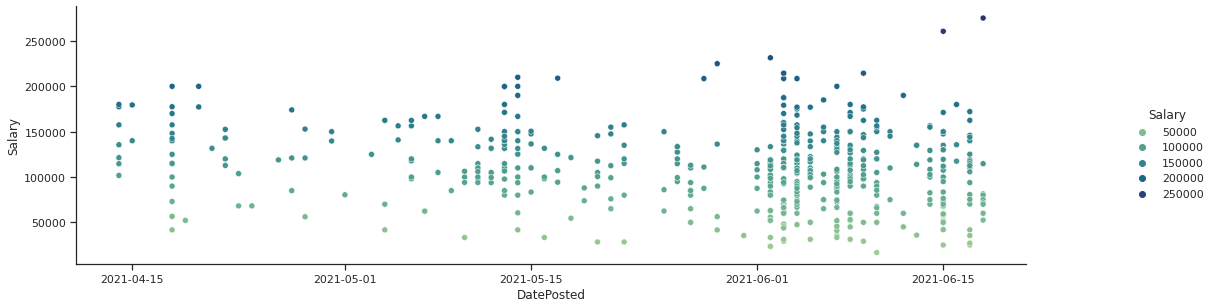

In [8]:
ax = sns.pairplot(data=munged[munged.Salary.notnull()],
                  x_vars=['DatePosted'],
                  y_vars=['Salary'], height=8, hue="Salary", palette="crest")

ax.fig.set_size_inches(18,4)

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.

In [9]:
outliers = []
def z_detect(munged):
    sample = munged[munged['Salary'].notnull()].Salary
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
z_detect(munged)

[275314.28571428574, 260714.28571428574]

#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.

In [10]:
def iqr_detect(munged):
    sample = munged[munged['Salary'].notnull()].Salary
    Q1, Q3 = np.percentile(sample,[25,75])
    iqr = Q3-Q1
    lower_bound = Q1-(1.5*iqr)
    upper_bound = Q3+(1.5*iqr)
    for i in sample:
        if (i < lower_bound)  | (i > upper_bound):
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return outliers
iqr_detect(munged)

[275314.28571428574,
 260714.28571428574,
 275314.28571428574,
 260714.28571428574,
 231500.0,
 225000.0]

In [11]:
def unique(list1):
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    for x in unique_list:
        print(x)
        
mn = min(outliers)
mx = max(outliers)
print(f'The {len(set(outliers))} Unique Outliers Are:')
unique(outliers)
print(f'- With a minumum of ${round(mn)} and a maximum of ${round(mx)}')

The 4 Unique Outliers Are:
225000.0
275314.28571428574
231500.0
260714.28571428574
- With a minumum of $225000 and a maximum of $275314


In [12]:
# Take a look at those tables.

outliers = munged[munged['Salary'].isin(outliers)]
munged.drop(outliers.index, axis=0,inplace=True)
outliers

,Company,JobTitle,Location,Summary,JobUrl,Requirements,Description,State,City,DatePosted,Schedule,Salary,Role,Focus
37,braintrust,sr. data engineer (no c2c),"San Francisco, CA",bachelor’s or advanced degree in information t...,https://www.indeed.com/rc/clk?jk=6bb716e4fc203...,none,job type freelance contract position no ag...,CA,san francisco,2021-06-18,hour,275314.285714,data engineer,senior
668,automated capital management,full stack developer,Remote,implement data pipelines that import and aggre...,https://www.indeed.com/company/Automated-Capit...,aws: 3 years (required)python: 5 years (requir...,full stack python django developer automated c...,Remote,remote,2021-06-15,hour,260714.285714,Other,
1700,ibm,"strategy and transformation leader, watson hea...","Austin, TX",ibm provides you with the most comprehensive a...,https://www.indeed.com/rc/clk?jk=b8f7af7c78f35...,none,introductionas a strategy consultant at ibm y...,TX,austin,2021-06-02,year,231500.000000,Other,senior
2111,red canary,principal data scientist,Remote,experience leading a team of data scientists ...,https://www.indeed.com/rc/clk?jk=e7d6512083edc...,none,who we arered canary was founded to create a w...,Remote,remote,2021-05-29,year,225000.000000,data scientist,


In [13]:
null = len(munged[munged.Salary.isnull()])
nnull = len(munged[munged.Salary.notnull()])

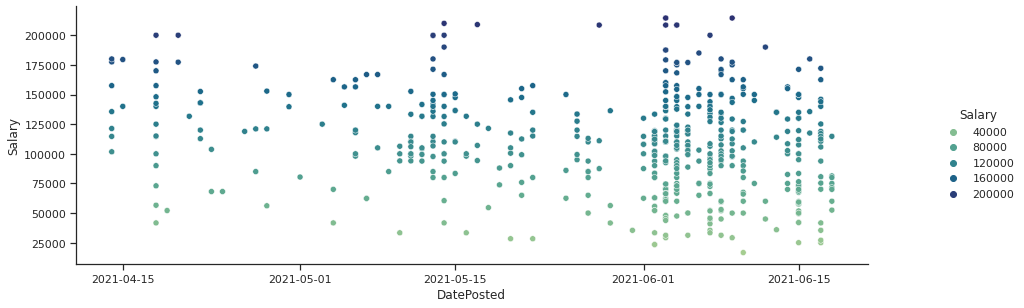

In [14]:
ax = sns.pairplot(data=munged[munged.Salary.notnull()],
                  x_vars=['DatePosted'],
                  y_vars=['Salary'], height=8, hue="Salary", palette="crest")

ax.fig.set_size_inches(15,4)

- Dropping 4 outliers now leaves 575, or 9.57%, of rows with with salary information,
- The remaining 5435 rows, or 90.43%, are missing salary data.


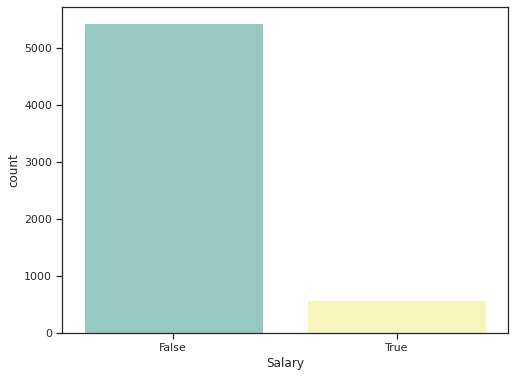

In [15]:
sns.countplot(x='Salary', data=munged.notnull(), palette='Set3')
print(f'- Dropping {len(outliers)} outliers now leaves {nnull}, or {round(nnull/len(munged)*100,2)}%, of rows with with salary information,\n- The remaining {null} rows, or {round(null/len(munged)*100,2)}%, are missing salary data.')


In [16]:
munged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6010 entries, 0 to 6013
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Company       6010 non-null   object        
 1   JobTitle      6010 non-null   object        
 2   Location      6010 non-null   object        
 3   Summary       6010 non-null   object        
 4   JobUrl        6010 non-null   object        
 5   Requirements  6010 non-null   object        
 6   Description   6010 non-null   object        
 7   State         6010 non-null   object        
 8   City          6010 non-null   object        
 9   DatePosted    6010 non-null   datetime64[ns]
 10  Schedule      602 non-null    object        
 11  Salary        575 non-null    float64       
 12  Role          6010 non-null   object        
 13  Focus         6010 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(12)
memory usage: 833.3+ KB


In [17]:
munged.to_csv(f'../data/munged_data.csv', index=False)